In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# set tensorflow log level, hide info, warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# force GPU device
os.environ["CUDA_VISIBLE_DEVICES"]='1'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout
from keras import Sequential, Input
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

load data from csv

In [4]:
checkpoint_path = 'saves/fnn'
model_path = f'{checkpoint_path}/model.keras'
log_path = f'{checkpoint_path}/log.csv'
history_path = f'{checkpoint_path}/history.npy'

# ensure directory exists
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [5]:
filter = False
filter_threshold = 5

data_directory = '/home/jrosendahl/datasets/cadets/sequences_export/'

data = []

labels = None
no_labels = None

no_features: int = None

count = 0
for file_name in os.listdir(data_directory):
    count += 1
    if count % 50000 == 0:
        print(f'Loaded {count} sequences')
    with open(data_directory + file_name, 'r') as f:
        if file_name.count('_') == 2:
            label, _, _ = file_name.split('_')
        elif file_name.count('_') == 3:
            # pwd_mkdb
            label, tmp, _, _ = file_name.split('_')
            label += '_' + tmp
        else:
            print(f'Unknown file name format: {file_name}')

        # collapse sequence to single datapoint
        datapoint = {}
        for line in f:
            line = line.strip()
            if line in datapoint:
                datapoint[line] += 1
            else:
                datapoint[line] = 1
        data.append((label, datapoint))

print(f'Loaded {len(data)} datapoints')


if filter:
    # filter out datapoints where label occurres less than 10 times
    label_occurrences = {}
    for label, _ in data:
        if label in label_occurrences:
            label_occurrences[label] += 1
        else:
            label_occurrences[label] = 1

    print(f'Filtered out datapoints with less than filter_threshold occurrences')
    data = [ x for x in data if label_occurrences[x[0]] >= filter_threshold ]
    print(f'Left with {len(data)} datapoints')

else:
    print(f'No filtering applied')

random.seed(42)
random.shuffle(data)
labels = [ x[0] for x in data ]
data = [ x[1] for x in data ]

distinct_labels = np.unique(np.array(labels))
no_labels = len(distinct_labels)
print(f'Found {no_labels} distinct labels')

# get distinct features
distinct_features = set()
for datapoint in data:
    distinct_features.update(datapoint.keys())
distinct_features = np.array(list(distinct_features))
no_features = len(distinct_features)
print(f'Found {no_features} distinct features')

# encode labels from strings to integers to one-hot
labels = np.eye(no_labels)[np.vectorize(distinct_labels.tolist().index)(labels)]
print(f'Encoded labels to one-hot')

# encode features from dictionary to numpy array
data_encoded = []
for datapoint in data:
    datapoint_encoded = np.zeros(no_features)
    for feature, count in datapoint.items():
        datapoint_encoded[distinct_features.tolist().index(feature)] = count
    data_encoded.append(datapoint_encoded)
print(f'Encoded features to numpy array')

Loaded 50000 sequences
Loaded 100000 sequences
Loaded 150000 sequences
Loaded 200000 sequences
Loaded 250000 sequences
Loaded 300000 sequences
Loaded 350000 sequences
Loaded 400000 sequences
Loaded 431895 datapoints
No filtering applied
Found 135 distinct labels
Found 29 distinct features
Encoded labels to one-hot
Encoded features to numpy array


split data

In [7]:
# naive split
split = int(len(data_encoded) * 0.75)

X_train = np.array(data_encoded[:split])
y_train = np.array(labels[:split])

X_val = np.array(data_encoded[split:])
y_val = np.array(labels[split:])

# split validation into validation and test, 50/50
split = int(len(X_val) * 0.5)

X_test = X_val[split:]
y_test = y_val[split:]

X_val = X_val[:split]
y_val = y_val[:split]


print(f'Training on {len(X_train)} samples')
print(f'Validating on {len(X_val)} samples')
print(f'Testing on {len(X_test)} samples')


# check how many labels are not present in sets
train_labels = set(np.argmax(y_train, axis=1))
val_labels = set(np.argmax(y_val, axis=1))
test_labels = set(np.argmax(y_test, axis=1))

total_labels = set(range(no_labels))

# print which labels do not occur in which set
print(f'Labels not in training: {total_labels - train_labels}')
print(f'Labels not in validation: {total_labels - val_labels}')
print(f'Labels not in testing: {total_labels - test_labels}')

Training on 323921 samples
Validating on 53987 samples
Testing on 53987 samples
Labels not in training: {54, 13, 14}
Labels not in validation: {0, 128, 132, 133, 8, 9, 12, 13, 19, 20, 23, 26, 33, 37, 38, 42, 44, 45, 50, 53, 56, 59, 61, 63, 64, 77, 78, 79, 81, 82, 84, 90, 91, 92, 94, 103, 106, 109, 113, 114, 116, 119, 124, 127}
Labels not in testing: {128, 132, 133, 6, 8, 14, 19, 20, 23, 29, 38, 41, 47, 48, 53, 54, 56, 59, 61, 63, 64, 66, 77, 80, 82, 87, 90, 91, 92, 94, 105, 106, 108, 109, 113, 114, 117, 119, 124, 127}


build model

In [8]:
model = Sequential(layers=[
    Input(shape=(no_features,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(no_labels, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 135)            │         8,775 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,015 (74.28 KB)

 Trainable params: 19,015 (74.28 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto'
)

model_checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-7
)

csv_logger = CSVLogger(
    filename=log_path,
    append=True
)

optimizer = Adam(learning_rate=0.0001)

# 'categorical_focal_crossentropy'
# 'categorical_crossentropy'
model.compile(optimizer=optimizer, loss='categorical_focal_crossentropy', metrics=['accuracy'])

train model

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=96,
    epochs=100,
    callbacks=[early_stop, model_checkpoint, lr_schedule, csv_logger]
)

# save history to file
with open(f'{checkpoint_path}/ffn_history.npy', 'wb') as f:
    np.save(f, history.history)

Epoch 1/100


I0000 00:00:1721380847.289882 1278508 service.cc:145] XLA service 0x76e7300030d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721380847.289944 1278508 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5


  58/3375 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0011 - loss: 1.4102     

I0000 00:00:1721380848.145317 1278508 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6159 - loss: 0.6256
Epoch 1: val_loss improved from inf to 0.20649, saving model to saves/fnn/model.keras
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6160 - loss: 0.6255 - val_accuracy: 0.8833 - val_loss: 0.2065 - learning_rate: 1.0000e-04
Epoch 2/100
3357/3375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8849 - loss: 0.2053
Epoch 2: val_loss improved from 0.20649 to 0.18775, saving model to saves/fnn/model.keras
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8849 - loss: 0.2053 - val_accuracy: 0.8953 - val_loss: 0.1878 - learning_rate: 1.0000e-04
Epoch 3/100
3371/3375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8941 - loss: 0.1897
Epoch 3: val_loss improved from 0.18775 to 0.18287, saving model to saves/fnn/model.keras
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8941 - loss: 0.1897 - val_accuracy: 0.8988 - val_loss: 0.1829 - learning_rate: 1.0000e-04
Epoch 4/100
3371/3375 ━━━━━━━━━━━━━

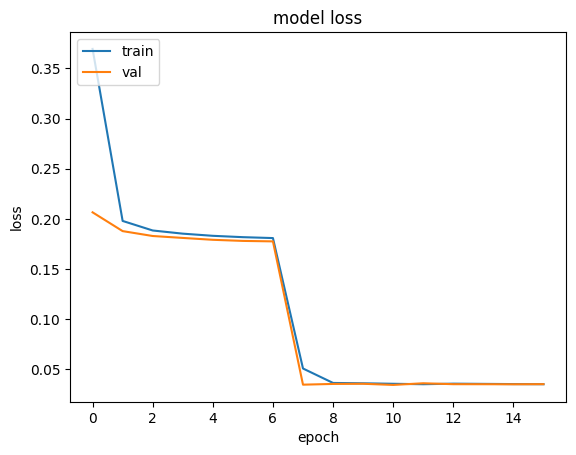

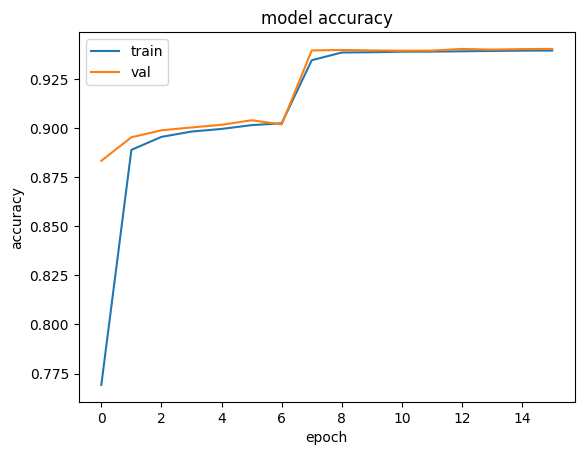

In [11]:
# plot history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

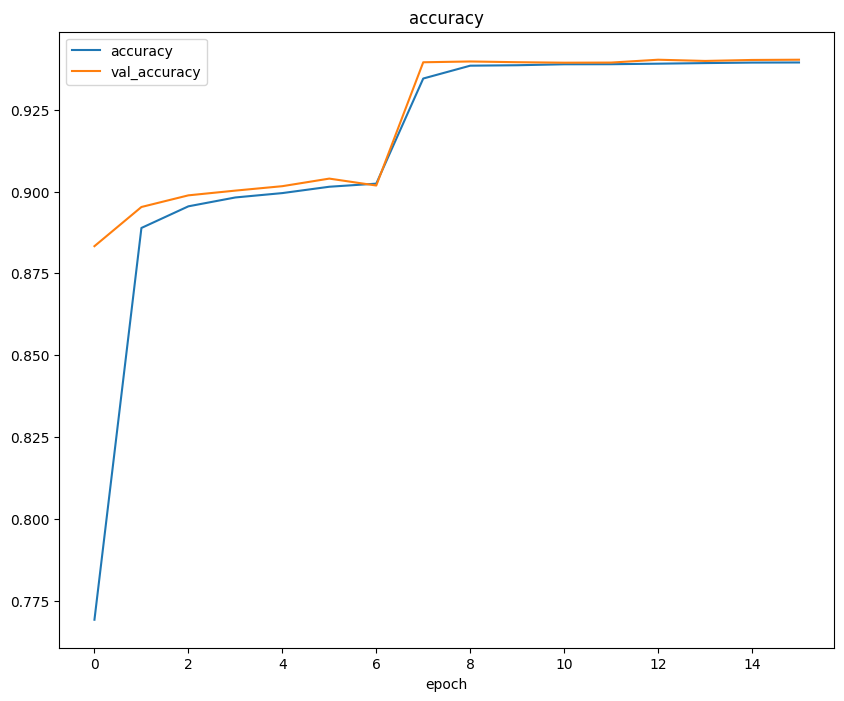

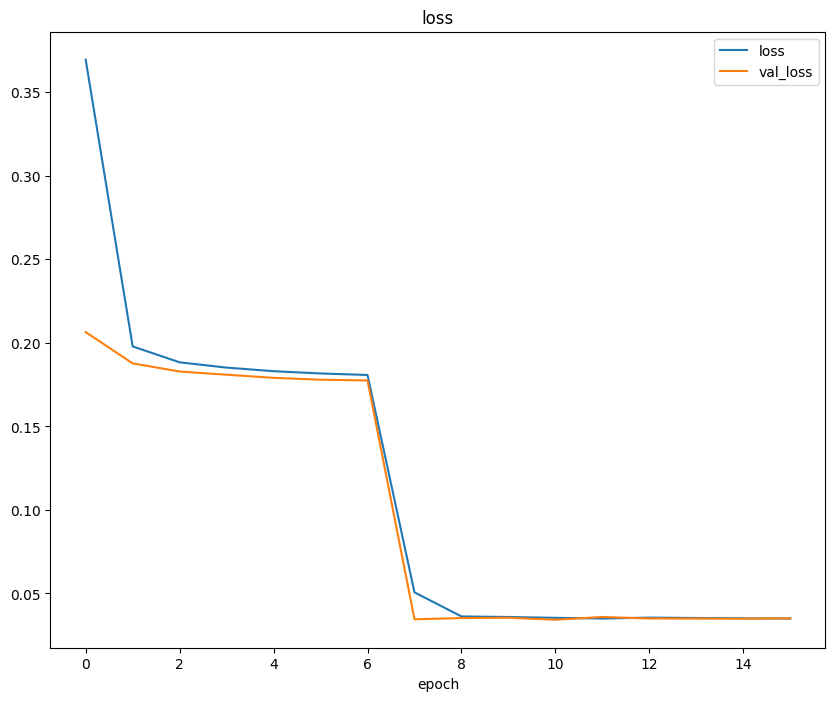

In [12]:
log = pd.read_csv(log_path)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(log['epoch'], log['accuracy'], label='accuracy')
ax.plot(log['epoch'], log['val_accuracy'], label='val_accuracy')
ax.set_title('accuracy')
ax.set_xlabel('epoch')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(log['epoch'], log['loss'], label='loss')
ax.plot(log['epoch'], log['val_loss'], label='val_loss')
ax.set_title('loss')
ax.set_xlabel('epoch')
ax.legend()

plt.show()

In [13]:
# evaluate model
score = model.evaluate(X_test, y_test)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9425 - loss: 0.0355
Test loss: 0.03636481612920761
Test accuracy: 0.9415414929389954


In [48]:
# print classification report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# print report, specify labels as not all labels might be present in test set
print(classification_report(y_true, y_pred, labels=np.unique(y_true)))

   1/1688 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        22
           2       0.94      0.48      0.64       135
           3       0.94      0.99      0.96       137
           4       1.00      1.00      1.00       341
           5       0.86      1.00      0.92         6
           7       0.95      0.97      0.96     19937
           9       0.33      0.50      0.40         2
          10       0.00      0.00      0.00         2
          11       0.84      0.86      0.85        36
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          15       1.00      0.99      1.00       144
          16       0.91      1.00      0.95        10
          17       1.00      1.00      1.00        54
          18       1.00      1.00      1.00      1334
          21       1.00      1.00     

/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

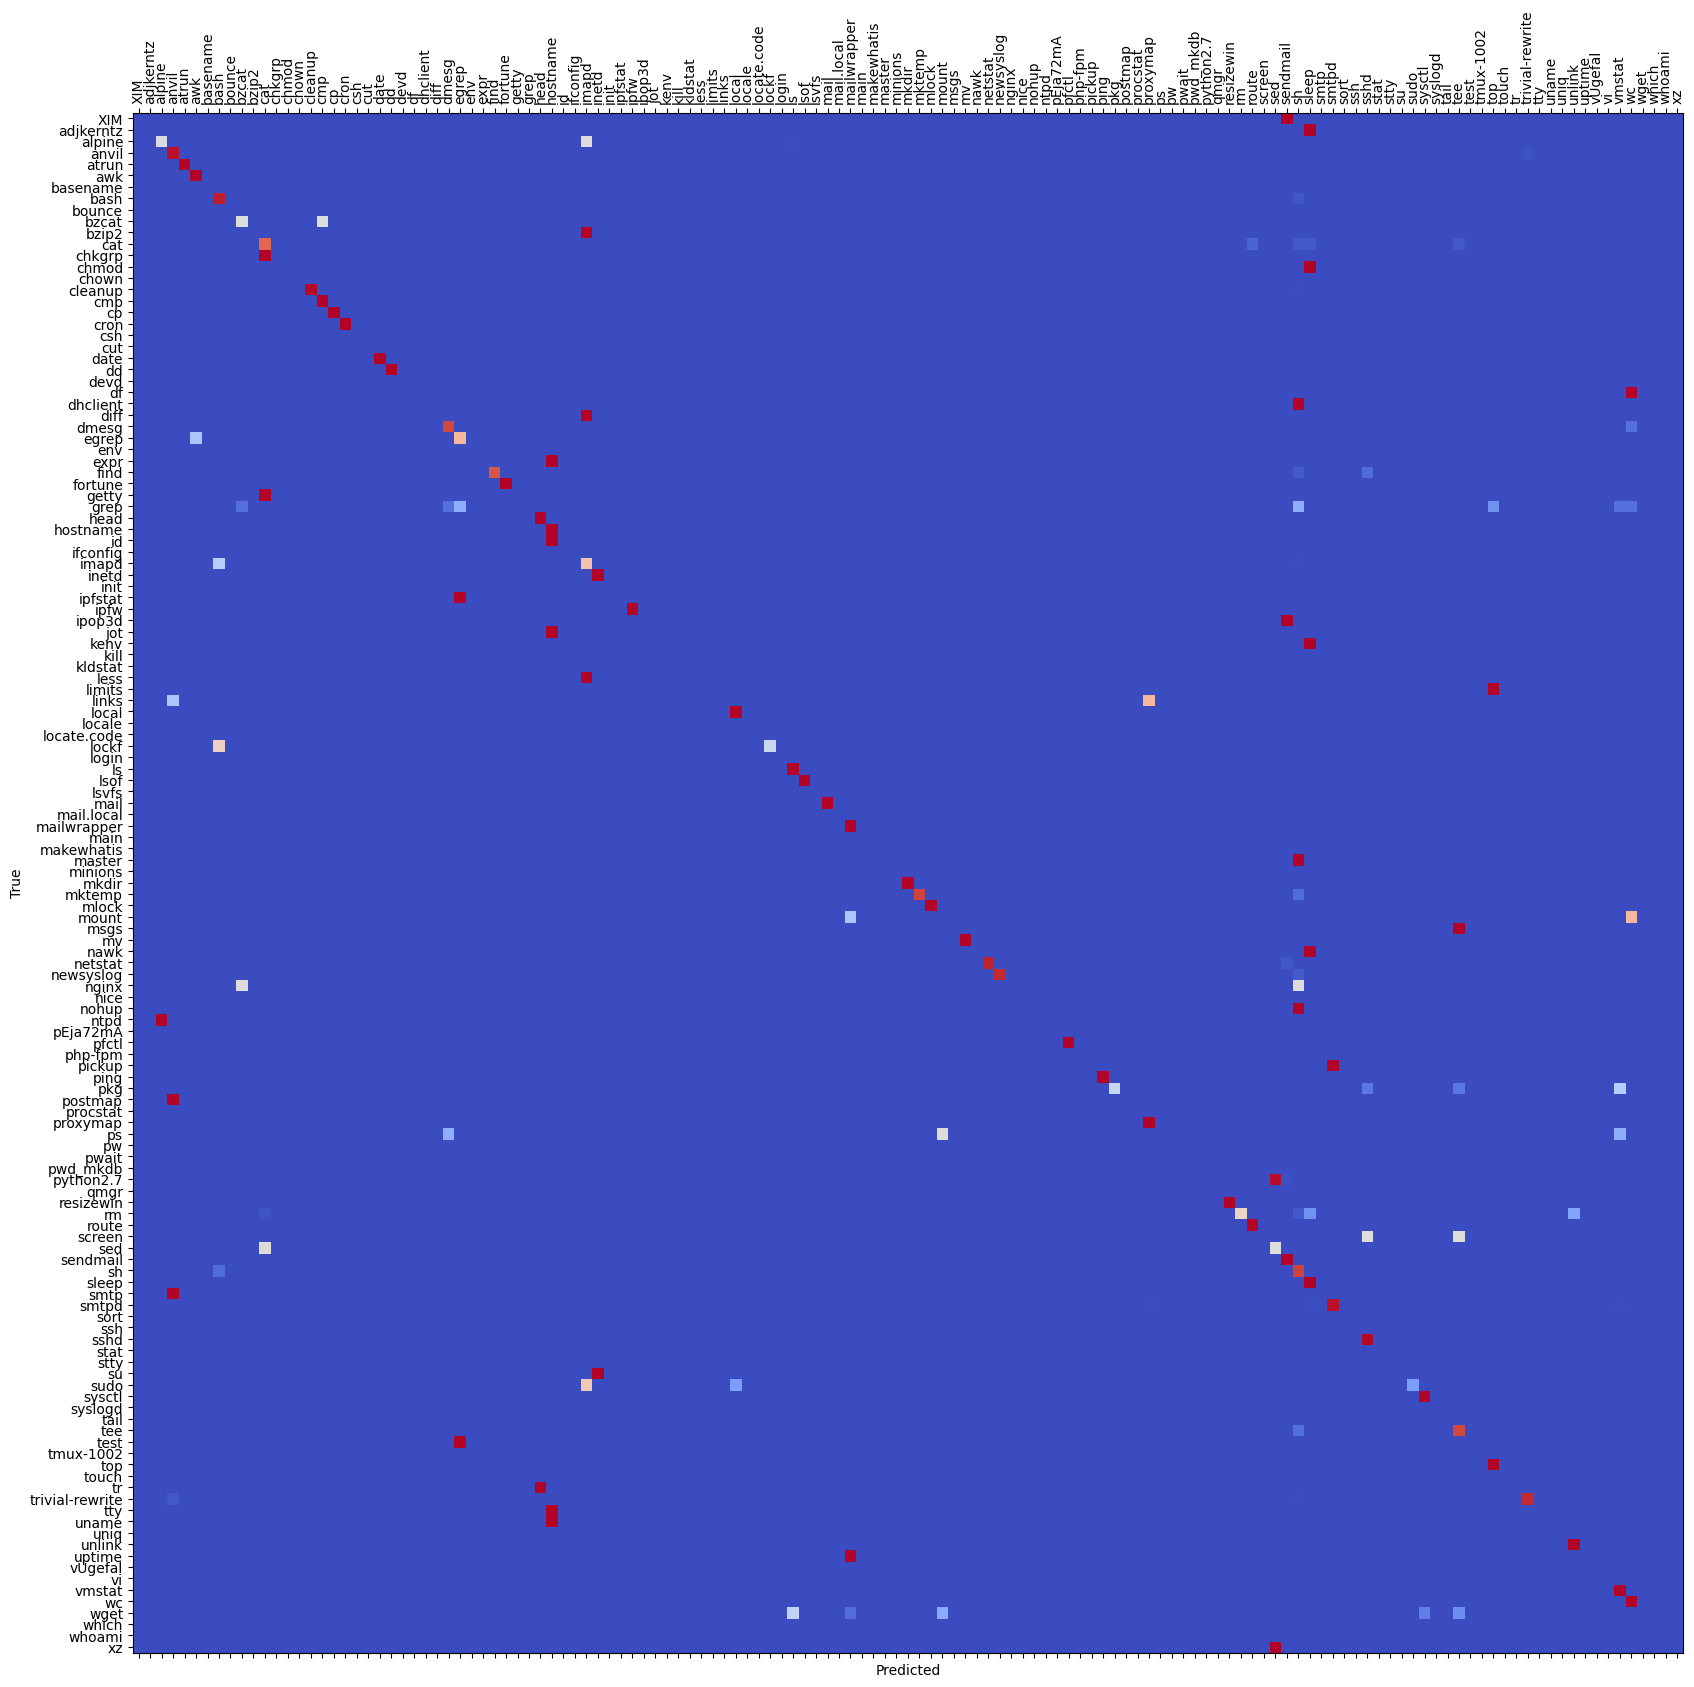

In [54]:
# plot confusion matrix, keep in mind that not all labels might be present in test set but should still be visualized as zeros

cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))

# transform to percentages
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# insert zero rows and columns for missing labels
for i in range(no_labels):
    if i not in np.unique(y_true):
        cm = np.insert(cm, i, 0, axis=0)
        cm = np.insert(cm, i, 0, axis=1)

fig, ax = plt.subplots(figsize=(20, 20))
cax = ax.matshow(cm, cmap='coolwarm', aspect='auto')

# set class names on axis
ax.set_xticks(range(no_labels))
ax.set_yticks(range(no_labels))
ax.set_xticklabels(distinct_labels, rotation=90)
ax.set_yticklabels(distinct_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
